# introduction

Objectif : Prédire par Réseaux de neurones une catégorie

Les prescriptions de médicaments comportent parfois des erreurs ou des risques potentiels qui nécessitent une intervention pharmaceutique (IP). Ce projet a pour objectif de développer deux modèles de classification pour prédire la nécessité et la nature de ces IPs, en se basant sur les commentaires de pharmaciens, selon les critères établis par la Société Française de Pharmacie Clinique. Le premier modèle est conçu pour prédire si une IP est classée comme « grave » ou « non-grave ». Le deuxième modèle vise à identifier la classe spécifique de l'IP parmi 11 catégories.

Les données utilisées proviennent des Hôpitaux Universitaires de Strasbourg. Après un prétraitement initial pour supprimer les lignes vides, deux colonnes cibles ont été créées à partir de la colonne 'PLT' : la première (IP_1) codifie la gravité de l'IP (1 pour « grave », 0 pour « non-grave »), tandis que la seconde (IP_2) correspond à la classe d'IP (de 1 à 11).

Ce travail met en lumière un outil potentiel pour assister les pharmaciens dans l'évaluation des IPs, en intégrant des modèles de classification avancés pour une prise de décision éclairée et sécurisée.

# import library

In [ ]:
import pandas as pd
import numpy as np

# DataManagement
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Split train/test
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from joblib import dump, load

# Modèle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, LSTM
import tensorflow as tf
from tensorflow.keras import layers, models

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

# import files

In [ ]:
!gdown 1foGLOCbc_OS_ODX3c2At0SiiZCt23vaV -O data_defi_2.csv

Downloading...
From: https://drive.google.com/uc?id=1foGLOCbc_OS_ODX3c2At0SiiZCt23vaV
To: /content/data_defi_2.csv
100% 3.08M/3.08M [00:00<00:00, 37.8MB/s]


In [ ]:
!gdown 1Mvx8EIZsgbPtbc2xukulgXT4_HArYbmV -O valid_set.csv

Downloading...
From: https://drive.google.com/uc?id=1Mvx8EIZsgbPtbc2xukulgXT4_HArYbmV
To: /content/valid_set.csv
100% 556k/556k [00:00<00:00, 81.8MB/s]


In [ ]:
data_defi_2 = pd.read_csv("data_defi_2.csv", sep =";", encoding='latin-1')
valid_set = pd.read_csv("valid_set.csv", sep =";")
display(data_defi_2.head())
display(valid_set.head())

,Column1,Column2,Column3
0,Libellé.Prescription,Avis.Pharmaceutique,PLT
1,"CONTRAMAL 100 MG/ML, GOUTTES BUV (TRAMADOL)",30/12/16 pas d'indication,5.3
2,"IMOVANE 7.5 MG, CPR SÉCABLE (ZOPICLONE)","22/12/16 recommandé -> IMOVANE 3,75MG CP, 1 au...",4.1
3,"COLCHICINE 1 MG, CPR SÉCABLE (COLCHICINE)","au vue de la DFG, il est recommandé d'administ...",4.1
4,"PANTOPRAZOLE 40 MG, CPR GASTRO-RÉSISTANT (EUPA...",Dose curative et absence d'ATCD gastrique retr...,4.1


,Libellé.Prescription,Avis.Pharmaceutique
0,perf NEFOPAM 60 mg (Acupan) + 1.25 DROPERIDOL ...,ASSOCIATION CONTRE INDIQUEE : SEROPLEX 20 MG C...
1,"LAMALINE, GÉLULE",Propose arrêt pendant hospitalisation ou DOLIP...
2,"XYZALL 5 MG, CPR","Non référencé aux HUS, propose CETIRIZINE 10MG..."
3,AMOXICILLINE + A.CLAVULANIQUE 1g x4/j (Augmentin),Il est recommandé de réduire la posologie en a...
4,"FELODIPINE LP 5 MG SANDOZ, CPR À LIBÉRATION PR...","Non référencé aux HUS, Substitué par amlodipin..."


# DataManagement

In [ ]:
#df["Column3"].value_counts()
#df.isnull().sum()
#df.info()

In [ ]:
df = data_defi_2.copy()
df.columns = df.iloc[0]
df = df.iloc[1:].reset_index(drop=True)
df = df.dropna(subset=['Avis.Pharmaceutique'])
df["text"] = df["Libellé.Prescription"] + " " + df["Avis.Pharmaceutique"]
def clean_text(t):
    t = t.lower()
    t = re.sub(r'[^a-zA-Zà-ÿ0-9\s]', '', t)
    return t
df["text"] = df["text"].apply(clean_text)
df['PLT'] = pd.to_numeric(df['PLT'], errors='coerce')
df['IP_1'] = np.where(df['PLT'].isin([4.1, 4.2, 5.1, 5.2, 5.3, 6.3, 6.4]), 1, 0)
df['IP_2'] = np.floor(df['PLT']).astype(int)
df = df.drop_duplicates().reset_index(drop=True)
df.head()

,Libellé.Prescription,Avis.Pharmaceutique,PLT,text,IP_1,IP_2
0,"CONTRAMAL 100 MG/ML, GOUTTES BUV (TRAMADOL)",30/12/16 pas d'indication,5.3,contramal 100 mgml gouttes buv tramadol 301216...,1,5
1,"IMOVANE 7.5 MG, CPR SÉCABLE (ZOPICLONE)","22/12/16 recommandé -> IMOVANE 3,75MG CP, 1 au...",4.1,imovane 75 mg cpr sécable zopiclone 221216 rec...,1,4
2,"COLCHICINE 1 MG, CPR SÉCABLE (COLCHICINE)","au vue de la DFG, il est recommandé d'administ...",4.1,colchicine 1 mg cpr sécable colchicine au vue ...,1,4
3,"PANTOPRAZOLE 40 MG, CPR GASTRO-RÉSISTANT (EUPA...",Dose curative et absence d'ATCD gastrique retr...,4.1,pantoprazole 40 mg cpr gastrorésistant eupanto...,1,4
4,VANCOMYCINE 500 mg 1x/j,posologie infraT veuillez réévaluer la posolog...,3.1,vancomycine 500 mg 1xj posologie infrat veuill...,0,3


# IP_1

## Split train/test

In [ ]:
X = df['text'].values
y = df['IP_1'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(max_features=10000)  # limite vocabulaire
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Conversion en dense
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

# SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_dense, y_train)

print(f"Avant SMOTE : {sum(y_train==1)}/{len(y_train)} positifs")
print(f"Après SMOTE  : {sum(y_train_res==1)}/{len(y_train_res)} positifs")

Avant SMOTE : 3622/18512 positifs
Après SMOTE  : 14890/29780 positifs


## Modèle

In [ ]:
model_IP_1 = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_dense.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # sortie binaire
])

model_IP_1.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model_IP_1.fit(X_train_dense, y_train,
                    validation_split=0.1,
                    epochs=4,
                    batch_size=32)

Epoch 1/4
521/521 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.8495 - loss: 0.3548 - val_accuracy: 0.9136 - val_loss: 0.2106
Epoch 2/4
521/521 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.9469 - loss: 0.1383 - val_accuracy: 0.9125 - val_loss: 0.2217
Epoch 3/4
521/521 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - accuracy: 0.9656 - loss: 0.0889 - val_accuracy: 0.9152 - val_loss: 0.2362
Epoch 4/4
521/521 ━━━━━━━━━━━━━━━━━━━━ 43s 46ms/step - accuracy: 0.9813 - loss: 0.0564 - val_accuracy: 0.9039 - val_loss: 0.3275


## evaluation

In [ ]:
y_pred_proba = model_IP_1.predict(X_test_dense)
y_pred = (y_pred_proba > 0.5).astype(int) # Convert probabilities to binary predictions

print(f"Accuracy : {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision : {precision_score(y_test, y_pred):.3f}")
print(f"Recall : {recall_score(y_test, y_pred):.3f}")
print(f"F1 score : {f1_score(y_test, y_pred):.3f}")
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))
print("Classification report :")
print(classification_report(y_test, y_pred))

145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Accuracy : 0.919
Precision : 0.865
Recall : 0.694
F1 score : 0.770
Matrice de confusion :
[[3625   98]
 [ 277  629]]
Classification report :
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      3723
           1       0.87      0.69      0.77       906

    accuracy                           0.92      4629
   macro avg       0.90      0.83      0.86      4629
weighted avg       0.92      0.92      0.92      4629



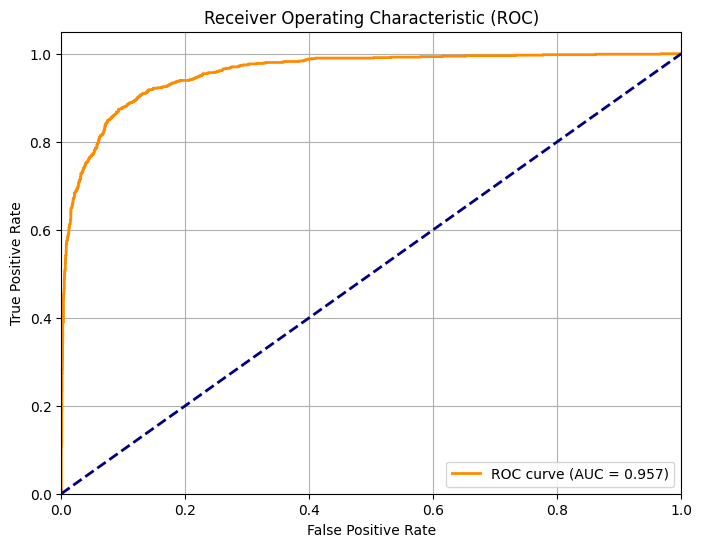

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # ligne diagonale
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# IP_2

## Split train/test

In [ ]:
X = df['text'].values
y = df['IP_2'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(max_features=10000)  # limite vocabulaire
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Conversion en dense
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

## Modèle

In [ ]:
num_classes = 12

model_IP_2 = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_dense.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # sortie multiclasse
])

model_IP_2.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model_IP_2.fit(X_train_dense, y_train,
                    validation_split=0.1,
                    epochs=4,
                    batch_size=32)

Epoch 1/4
521/521 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - accuracy: 0.5930 - loss: 1.3549 - val_accuracy: 0.7592 - val_loss: 0.7518
Epoch 2/4
521/521 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.8472 - loss: 0.4885 - val_accuracy: 0.7657 - val_loss: 0.7331
Epoch 3/4
521/521 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.9120 - loss: 0.2868 - val_accuracy: 0.7694 - val_loss: 0.7782
Epoch 4/4
521/521 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.9408 - loss: 0.1873 - val_accuracy: 0.7630 - val_loss: 0.8762


## evaluation

In [ ]:
y_pred_proba = model_IP_2.predict(X_test_dense)
y_pred = y_pred_proba.argmax(axis=1)

print(f"Accuracy : {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision : {precision_score(y_test, y_pred, average='macro'):.3f}")
print(f"Recall : {recall_score(y_test, y_pred, average='macro'):.3f}")
print(f"F1 score : {f1_score(y_test, y_pred, average='macro'):.3f}")
print("Classification report :")
print(classification_report(y_test, y_pred))

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Accuracy : 0.781
Precision : 0.573
Recall : 0.553
F1 score : 0.561
Classification report :
              precision    recall  f1-score   support

           1       0.88      0.88      0.88      2253
           2       0.81      0.72      0.76       151
           3       0.50      0.37      0.42       194
           4       0.69      0.80      0.74       613
           5       0.63      0.58      0.60       166
           6       0.82      0.85      0.83       193
           7       0.00      0.00      0.00         2
           8       0.73      0.77      0.75       589
           9       0.00      0.00      0.00         4
          10       0.70      0.61      0.65       148
          11       0.54      0.49      0.51       316

    accuracy                           0.78      4629
   macro avg       0.57      0.55      0.56      4629
weighted avg       0.78      0.78      0.78      4629



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

# Test

In [ ]:
df_test = valid_set.copy()
df_test = df_test.dropna(subset=['Avis.Pharmaceutique'])
df_test["text"] = df_test["Libellé.Prescription"] + df_test["Avis.Pharmaceutique"]
def clean_text(t):
    t = t.lower()
    t = re.sub(r'[^a-zA-Zà-ÿ0-9\s]', '', t)
    return t
df_test["text"] = df_test["text"].apply(clean_text)
df_test.head()

,Libellé.Prescription,Avis.Pharmaceutique,text
0,perf NEFOPAM 60 mg (Acupan) + 1.25 DROPERIDOL ...,ASSOCIATION CONTRE INDIQUEE : SEROPLEX 20 MG C...,perf nefopam 60 mg acupan 125 droperidol drol...
1,"LAMALINE, GÉLULE",Propose arrêt pendant hospitalisation ou DOLIP...,lamaline gélulepropose arrêt pendant hospitali...
2,"XYZALL 5 MG, CPR","Non référencé aux HUS, propose CETIRIZINE 10MG...",xyzall 5 mg cprnon référencé aux hus propose c...
3,AMOXICILLINE + A.CLAVULANIQUE 1g x4/j (Augmentin),Il est recommandé de réduire la posologie en a...,amoxicilline aclavulanique 1g x4j augmentinil...
4,"FELODIPINE LP 5 MG SANDOZ, CPR À LIBÉRATION PR...","Non référencé aux HUS, Substitué par amlodipin...",felodipine lp 5 mg sandoz cpr à libération pro...


In [ ]:
X_test_tfidf = vectorizer.transform(df_test["text"])
X_test_dense = X_test_tfidf.toarray()

pred_ip1 = model_IP_1.predict(X_test_dense)
pred_ip1 = (pred_ip1 > 0.5).astype("int32").flatten()

pred_ip2 = model_IP_2.predict(X_test_dense)
pred_ip2 = np.argmax(pred_ip2, axis=1) + 1

result = pd.DataFrame({
    'Prescription': df_test['Libellé.Prescription	'],
    'IP1': pred_ip1,
    'IP2': pred_ip2
})

result.head()

InvalidArgumentError: Graph execution error:

Detected at node sequential_1/dense_1/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.12/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-3948838717.py", line 11, in <cell line: 0>

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 566, in predict

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 260, in one_step_on_data_distributed

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 250, in one_step_on_data

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 105, in predict_step

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/sequential.py", line 220, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py", line 183, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/function.py", line 177, in _run_through_graph

  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py", line 648, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py", line 155, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/activations/activations.py", line 47, in relu

  File "/usr/local/lib/python3.12/dist-packages/keras/src/activations/activations.py", line 101, in static_call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py", line 15, in relu

Matrix size-incompatible: In[0]: [32,7814], In[1]: [10000,256]
	 [[{{node sequential_1/dense_1/Relu}}]] [Op:__inference_one_step_on_data_distributed_52952]

In [ ]:
X_train = df_test["text"]

vectorizer = TfidfVectorizer(max_features=10000)  # limite vocabulaire
X_train_tfidf = vectorizer.fit_transform(X_train)

# Conversion en dense
X_train_dense = X_train_tfidf.toarray()

# Modèle

y_pred_1 = model_IP_1.predict(X_train_dense)
y_pred_1 = (y_pred_1 > 0.5).astype("int32").flatten()

y_pred_2 = model_IP_2.predict(X_train_dense)
y_pred_2 = np.argmax(y_pred_2, axis=1)

### Résultat

y_pred_1 = pd.Series(y_pred_1, name="IP_1")
y_pred_2 = pd.Series(y_pred_2, name="IP_2")
result = pd.concat([df_test, y_pred_1, y_pred_2], axis=1)

result.head()

NotFittedError: The TF-IDF vectorizer is not fitted

In [ ]:
display(result.groupby('Statue').size())
display(result.groupby('Classe').size())